In [2]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
      OptimizationOptimisers, Random, Plots
using ArrheniusModel
using RecursiveArrayTools
using Statistics
using Enzyme

In [4]:
using Dates
timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")

"2024-09-12_02-12-39"

In [3]:
# example from tests
G = [1.0,0.0]
Ea = [0. 0.2; 0.2 0.]
pe = PhaseEnergies(G, Ea)

PhaseEnergies([1.0, 0.0], [0.0 0.2; 0.2 0.0], [0.0 0.2; 1.2 0.0])

In [5]:
# try forward mode without the struct first
# this will give the derivative of each element of the output matrix wrt the 1,2 element of the input
db = Array(zero(pe.barriers))
db[1,2] = 1.0
g12 = Enzyme.autodiff(Reverse, arrhenius_rate, Active, Duplicated(pe.barriers, db))[1]
# (convince yourself that this gives the right result)

MethodError: MethodError: no method matching arrhenius_rate!(::Matrix{Float64})

Closest candidates are:
  arrhenius_rate!(::Matrix, !Matched::Matrix, !Matched::Any)
   @ ArrheniusModel ~/.julia/packages/ArrheniusModel/Ng3qE/src/newArrheniusEq.jl:54
  arrhenius_rate!(::Matrix, !Matched::Matrix)
   @ ArrheniusModel ~/.julia/packages/ArrheniusModel/Ng3qE/src/newArrheniusEq.jl:54
  arrhenius_rate!(!Matched::PhaseEnergies, !Matched::Matrix, !Matched::Any)
   @ ArrheniusModel ~/.julia/packages/ArrheniusModel/Ng3qE/src/newArrheniusEq.jl:60
  ...


In [7]:
db = zero(pe.barriers)
K = zero(pe.barriers)
dK = copy(K)
dK[1,2] = 1.0
Enzyme.autodiff(Reverse, arrhenius_rate!, Duplicated(pe.barriers, db), Duplicated(K, dK))

((nothing, nothing),)

In [8]:
db

2×2 Matrix{Float64}:
 0.0  -0.0168865
 0.0   0.0

In [38]:
db = Array(zero(pe.barriers))
db[2,2] = 1.0
g22 = Enzyme.autodiff(Forward, arrhenius_rate, Duplicated, Duplicated(pe.barriers, db))[2]


2×2 Matrix{Float64}:
  0.0  -0.0
 -0.0   0.0

In [2]:
rng = Xoshiro(0)
G = [-5.92, -5.942, -5.97]
Ea = [0.00 1.00 0.01; 1.00 0.00 1.00; 0.01 1.00 0.00]
pe = PhaseEnergies(G, Ea)
T = 300.0
K = arrhenius_rate(pe.barriers, T)

3×3 Matrix{Float64}:
 -0.679205      1.58522e-17   0.679205
  6.76849e-18  -2.26207e-17   1.58522e-17
  0.098176      5.36651e-18  -0.098176

In [3]:
t= 10
dt = 0.05
datasize = Int(t/0.5+1)
num_steps = floor(Int, t/dt)
num_layers = floor(Int, t/0.5)+1
flow_rate = 0.5
decay_coefficient = 0.00001 * flow_rate
fcoeff = flow_coefficient("exponential", num_layers, decay_coefficient)
n = n_phases(pe)
c0 = zeros(num_layers, n)
c0[1, 1] = 1.0
j = 0
j0 = 0
p = (fcoeff, j0, j, dt, num_steps, num_layers)
tspan = (0.0, (num_steps-1) * dt)
tsteps = range(tspan[1], tspan[2]; length = datasize)

0.0:0.49750000000000005:9.950000000000001

In [4]:
function deposition_rates!(dc, c, p, t)
    # Unpack parameters
    fcoeff, j0, j, dt, num_steps, num_layers = p
    # Calculate deposition rates
    j = floor(Int, t / 0.5) + 1
    f = reverse(fcoeff[j: num_layers+j-1])
    dc .= c .* f * K
    if j != j0
        c[j+1, 1] = 1.0
        j = j0
    end
end

prob = ODEProblem(deposition_rates!, c0, tspan, p)
ode_data = Array(solve(prob, Euler(), saveat = 0.5, dt = dt)) #Training data

ode_data_avg = mean(ode_data, dims=1)
ode_data_avg = reshape(ode_data_avg, (3, 21))
ode_data

21×3×21 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.714042      7.20251e-18   0.285958
 1.0          -9.76963e-49  -4.1859e-32
 3.64848e-30   0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 ⋮                          
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0

In [6]:


function ODE_calculation(barriers=pe.barriers, T=T, prob=prob)
    K = arrhenius_rate(barriers, T)
    ode_data = Array(solve(prob, Euler(), saveat = 0.5, dt = 0.05))
    return ode_data[:,:,end]
end

ODE_calculation(pe.barriers, T)

21×3 Matrix{Float64}:
 0.126618  7.83502e-17  0.873382
 0.126797  7.46682e-17  0.873203
 0.127014  7.16547e-17  0.872986
 0.127367  6.83049e-17  0.872633
 0.12789   6.49527e-17  0.87211
 0.128764  6.12613e-17  0.871236
 0.129967  5.78999e-17  0.870033
 0.131756  5.45307e-17  0.868244
 0.134415  5.11496e-17  0.865585
 0.138367  4.77511e-17  0.861633
 ⋮                      
 0.165958  3.73433e-17  0.834042
 0.185257  3.37378e-17  0.814743
 0.213945  3.00056e-17  0.786055
 0.25659   2.60851e-17  0.74341
 0.319983  2.18847e-17  0.680017
 0.414218  1.72683e-17  0.585782
 0.554302  1.20334e-17  0.445698
 0.737811  6.54736e-18  0.262189
 1.0       0.0          0.0

In [7]:
db = Array(zero(pe.barriers))
dT = 1.0
godeT = Enzyme.autodiff(Forward,
 ODE_calculation,
 Duplicated(pe.barriers, db), 
 Duplicated(T,dT), 
 Const(prob))[1]
end

Enzyme.Compiler.EnzymeRuntimeException: Enzyme execution failed.
Mismatched activity for:   store i64 %bitcast_coercion, i64 addrspace(11)* %46, align 8, !dbg !340, !tbaa !264, !alias.scope !268, !noalias !347 const val:   %bitcast_coercion = ptrtoint {}* %39 to i64, !dbg !341
Type tree: {[-1]:Pointer}
 llvalue=  %bitcast_coercion = ptrtoint {}* %39 to i64, !dbg !341
You may be using a constant variable as temporary storage for active memory (https://enzyme.mit.edu/julia/stable/faq/#Activity-of-temporary-storage). If not, please open an issue, and either rewrite this variable to not be conditionally active or use Enzyme.API.runtimeActivity!(true) as a workaround for now

Stacktrace:
 [1] FunctionWrapper
   @ C:\Users\heyye\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:107
 [2] #113
   @ C:\Users\heyye\.julia\packages\DiffEqBase\c8MAQ\src\norecompile.jl:71
 [3] map
   @ .\tuple.jl:322
 [4] wrapfun_iip
   @ C:\Users\heyye\.julia\packages\DiffEqBase\c8MAQ\src\norecompile.jl:70
 [5] promote_f
   @ C:\Users\heyye\.julia\packages\DiffEqBase\c8MAQ\src\solve.jl:1260
 [6] #get_concrete_problem#69
   @ C:\Users\heyye\.julia\packages\DiffEqBase\c8MAQ\src\solve.jl:1173


In [9]:
function simple_ode!(du, u, p, t)
    a = p[1]
    du[1] = -a * u[1]
end

# Define the ODE calculation function
function ODE_calculation(u0, p, tspan)
    prob = ODEProblem(simple_ode!, u0, tspan, p)
    sol = solve(prob, Tsit5())
    return sol[end]
end
# Define the parameters and initial conditions
u0 = [1.0]  # Initial condition
a = 2.0     # Parameter
p = [a]
tspan = (0.0, 1.0)

# Compute the sensitivity with respect to the parameter 'a' using Enzyme.autodiff
da = 1.0  # Perturbation for parameter 'a'
sensitivity = Enzyme.autodiff(Forward, ODE_calculation, Const(u0), Const(p), Const(tspan))

println("Sensitivity with respect to parameter 'a': ", sensitivity)

Enzyme.Compiler.EnzymeRuntimeException: Enzyme execution failed.
Mismatched activity for:   ret {} addrspace(10)* %16, !dbg !29 const val:   %16 = call nonnull "enzyme_type"="{[-1]:Pointer}" {} addrspace(10)* @ijl_matching_methods({} addrspace(10)* nonnull %12, {} addrspace(10)* noundef addrspacecast ({}* inttoptr (i64 2055464484872 to {}*) to {} addrspace(10)*), i32 %15, i32 noundef 0, i64 %2, i64 noundef %bitcast_coercion, i64 noundef %bitcast_coercion7, i64 noundef 0) #14 [ "jl_roots"({} addrspace(10)* null, {} addrspace(10)* null) ], !dbg !57
Type tree: {}
 llvalue=  %16 = call nonnull "enzyme_type"="{[-1]:Pointer}" {} addrspace(10)* @ijl_matching_methods({} addrspace(10)* nonnull %12, {} addrspace(10)* noundef addrspacecast ({}* inttoptr (i64 2055464484872 to {}*) to {} addrspace(10)*), i32 %15, i32 noundef 0, i64 %2, i64 noundef %bitcast_coercion, i64 noundef %bitcast_coercion7, i64 noundef 0) #14 [ "jl_roots"({} addrspace(10)* null, {} addrspace(10)* null) ], !dbg !57
You may be using a constant variable as temporary storage for active memory (https://enzyme.mit.edu/julia/stable/faq/#Activity-of-temporary-storage). If not, please open an issue, and either rewrite this variable to not be conditionally active or use Enzyme.API.runtimeActivity!(true) as a workaround for now

Stacktrace:
 [1] _methods
   @ .\reflection.jl:1021


In [6]:
ode_data_avg

3×21 Matrix{Float64}:
 0.047619  0.081621     0.155214     0.173523     …  0.298417    0.259249
 0.0       3.42976e-19  9.37616e-19  1.81087e-18     3.9491e-17  4.28866e-17
 0.0       0.0136171    0.0352625    0.0645725       0.701583    0.740751

In [9]:
inputs = [T, flow_rate]
input_size = length(inputs)  # Replace with the actual size of `inputs` if it's not a 1D vector
Ea_size = (n ^ 2 - n) ÷ 2
fcoeff_size = length(fcoeff) #sigmoid 0~1
precoeff_size = 1
output_size = Ea_size + fcoeff_size + precoeff_size
nn = Chain(
    Dense(input_size, input_size*3*n, tanh),
    Dense(input_size*3*n, output_size*2, tanh),
    Dense(output_size*2, output_size, sigmoid)
)
#Combine activation functions and setup constraints
#Normalize the input


Chain(
    layer_1 = Dense(2 => 18, tanh_fast),  # 54 parameters
    layer_2 = Dense(18 => 90, tanh_fast),  # 1_710 parameters
    layer_3 = Dense(90 => 45, sigmoid_fast),  # 4_095 parameters
)         # Total: 5_859 parameters,
          #        plus 0 states.

In [10]:
#For debugging

dp, dst = Lux.setup(rng, nn)
model_debug = Lux.Experimental.@debug_mode nn

try
    model_debug(inputs, dp, dst)
catch e
    println(e)
end

┌ Info: Input Type: Vector{Float64} | Input Structure: (2,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:68
┌ Info: Running Layer: Dense(2 => 18, tanh_fast) at location KeyPath(:nn, :layers, :layer_1)!
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:69
┌ Info: Output Type: Vector{Float64} | Output Structure: (18,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:83
┌ Info: Input Type: Vector{Float64} | Input Structure: (18,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:68
┌ Info: Running Layer: Dense(18 => 90, tanh_fast) at location KeyPath(:nn, :layers, :layer_2)!
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:69
┌ Info: Output Type: Vector{Float64} | Output Structure: (90,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:83
┌ Info: Input Type: Vector{Float64} | Input Stru

([0.43193563189375017, 0.5308308510056458, 0.4485011782400952, 0.43707332089605455, 0.6409409546229725, 0.3576397409737823, 0.5236457162878858, 0.6402207548534851, 0.5922414448434998, 0.49377781835325557  …  0.6992370511860252, 0.46187258110677226, 0.47928820759146074, 0.3644116047392325, 0.6118871168775296, 0.46845285563492867, 0.5772983250286146, 0.6118653215094058, 0.6382462176842046, 0.6391563882407825], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [11]:
p, st = Lux.setup(rng, nn)

((layer_1 = (weight = Float32[0.29111657 0.08515933; -0.080986746 -0.070477866; … ; -0.060664695 -0.22728781; -0.09986522 0.13429996], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.046951532 -0.144725 … -0.18363486 -0.22843021; -0.1636454 0.21349101 … 0.051324606 0.11366334; … ; -0.08811172 -0.08436127 … -0.13163702 0.12956446; 0.21483207 -0.06516268 … 0.22743249 0.097471416], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.00037885775 -0.084558815 … -0.17000854 0.10799954; -0.06524792 0.08792385 … -0.06394141 0.037802212; … ; 0.104102895 -0.20743752 … 0.08706093 -0.04830865; 0.1035926 -0.20600359 … 0.15626843 0.17548831], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [7]:
println(j,j0,c0)

00[1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]


In [15]:
function model_rates!(du, u, p, t)
    # Unpack parameters
    p_pe, p_fcoeff, p_precoeff = p
    # Calculate deposition rates
    j = floor(Int, t / 0.5) + 1
    f = reverse(p_fcoeff[j: num_layers+j-1])
    du .= p_precoeff * u .* f * p_pe.K
    if j != j0
        u[j+1, 1] = 1.0
        j = j0
    end
end

function predict_neuralode(p)
    # Get parameters from the neural network
    inputs = [0.1, flow_rate] #Normalize 300K to 0.1 at this time point
    output, outst = nn(inputs, p, st)

    # Segregate the output
    pp_Ea = output[1:Ea_size]
    p_Ea = zeros(n, n)
    index = 1
    for i in 1:n
        for j in i+1:n
            p_Ea[i, j] = pp_Ea[index]
            p_Ea[j, i] = pp_Ea[index]
            index += 1
        end
    end
    p_fcoeff = output[Ea_size+1:Ea_size+fcoeff_size]
    p_precoeff = output[end]  # The last element
    p_pe = PhaseEnergies(G, p_Ea)
    # Amorphous phase goes to zero
    nn_output = (p_pe, p_fcoeff, p_precoeff)
    arrhenius_rate(p_pe, T)

    # Define the ODE problem with the parameters from the neural network
    prob = ODEProblem(model_rates!, c0, tspan, nn_output)

    # Solve the ODE
    sol = solve(prob, Euler(), saveat = 0.5, dt = dt)
    return Array(sol)
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

T = 300.0  # Example temperature
flow_rate = 1.0  # Example flow rate
#ps = T, flow_rate, p, st, ode_data
# Predict using the NeuralODE
pred = predict_neuralode(p)
println("Training data: ", size(ode_data))
println("Prediction:", size(pred))
println("Training size: ", size(ode_data[:, :, 1]))
println(pred[:, :, 4])
println("prediction size: ", size(pred[:, :, 1]))
#!!Instability happens at 4th timestep since the weights are randomly initialized (num too large)

# Calculate loss
loss, pred = loss_neuralode(p)

println("Loss: ", loss)
println("Prediction: ", pred)

Training data: (21, 3, 21)
Prediction:(21, 3, 21)
Training size: (21, 3)
[0.9999999996245214 2.523222108420867e-10 1.2315566607976783e-10; 0.9999999997597571 2.488181803765167e-10 1.2144538776306554e-10; 0.9999999998628969 1.6009121818962328e-10 7.813874388096095e-11; 0.9999999999855532 8.737442474703263e-11 4.264648538459838e-11; 1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
prediction size: (21, 3)
Loss: 230.09808158705212
Prediction: [1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.9999999998773437 8.242506286455798e-11 4.023075687132736e-11; 1.0 8.737442474703273e-11 4.2646485384598436

In [16]:
println(size(ode_data[:,1,:]), ode_data[:,1,:])
println(size(ode_data))
#Average the ode_data to get the average concentration of each phase at every timestep
ode_data_avg = mean(ode_data, dims=1)
ode_data_avg = reshape(ode_data_avg, (3, 21))
println(size(ode_data_avg))
display(ode_data_avg[:,:])

3×21 Matrix{Float64}:
 0.047619  0.081621     0.155214     0.173523     …  0.298417    0.259249
 0.0       3.42976e-19  9.37616e-19  1.81087e-18     3.9491e-17  4.28866e-17
 0.0       0.0136171    0.0352625    0.0645725       0.701583    0.740751

(21, 21)[1.0 0.7140418066239524 0.5216762060296549 0.39227071343540376 0.3052186330850872 0.24665790382769046 0.20726347055526823 0.18076237380129176 0.16293473951705625 0.15094183259120358 0.1428740146711837 0.13744665514935134 0.13379556990798105 0.13133941229777385 0.12968710291440183 0.1285755570563149 0.12782779352898554 0.12732475407337257 0.12698634601215097 0.12675868942146867 0.126618268501075; 0.0 1.0 0.7378108976008431 0.5376659722865966 0.4030271981415452 0.3124546486293472 0.2515256423015424 0.21053806885984885 0.18296524805093942 0.16441665098232047 0.15193874198427695 0.14354465550956397 0.13789780953370603 0.1340990716907807 0.13154358524078993 0.12982445523754738 0.12866795763858224 0.12788995399828396 0.12736657125310205 0.12701447771829566 0.12679730323419702; 0.0 3.648481686647177e-30 1.0000000000000002 0.7140418066239528 0.5216762859778709 0.39227076721741294 0.3052186330854632 0.24665787948969678 0.20726345418274675 0.18076236278723673 0.1629347321077117 0.1509418

In [10]:
propertynames(nn)

(:layers, :name)

In [11]:
propertynames(nn.layers[1])

(:activation, :in_dims, :out_dims, :init_weight, :init_bias)

In [19]:
# Callback function to observe training
loss_values = Float64[]
callback = function (p, l, pred; doplot = false)
    println(l)
    push!(loss_values, l)
    # plot current prediction against data
    if doplot
        pred_avg = mean(pred, dims=1)
        pred_avg = reshape(pred_avg, (3, 21))
        #plot the three phases from ode_data_avg and pred_avg
        plt = scatter(tsteps, ode_data_avg[1, :], label = "Phase 1 Data", color = :blue)
        scatter!(plt, tsteps, ode_data_avg[2, :], label = "Phase 2 Data", color = :red)
        scatter!(plt, tsteps, ode_data_avg[3, :], label = "Phase 3 Data", color = :green)
        scatter!(plt, tsteps, pred_avg[1, :], label = "Phase 1 Prediction", color = :blue, shape = :cross)
        scatter!(plt, tsteps, pred_avg[2, :], label = "Phase 2 Prediction", color = :red, shape = :cross)
        scatter!(plt, tsteps, pred_avg[3, :], label = "Phase 3 Prediction", color = :green, shape = :cross)
        display(plot(plt))
        savefig(plt, "training_$timestamp.svg")
    end
    return false
end

pinit = ComponentArray(p)

callback(pinit, loss_neuralode(pinit)...)

230.09808158705212


false

In [13]:
println(typeof(pinit))

ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = ViewAxis(1:102, Axis(weight = ViewAxis(1:68, ShapedAxis((34, 2))), bias = ViewAxis(69:102, ShapedAxis((34, 1))))), layer_2 = ViewAxis(103:3672, Axis(weight = ViewAxis(1:3468, ShapedAxis((102, 34))), bias = ViewAxis(3469:3570, ShapedAxis((102, 1))))), layer_3 = ViewAxis(3673:8925, Axis(weight = ViewAxis(1:5202, ShapedAxis((51, 102))), bias = ViewAxis(5203:5253, ShapedAxis((51, 1))))))}}}


In [20]:
# Train using the Adam optimizer
adtype = Optimization.AutoFiniteDiff()

optf = Optimization.OptimizationFunction((p,_) -> loss_neuralode(p), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(0.02); callback = callback, maxiters = 50)


230.09808158705212
230.08818487791513
219.9399543250836
64.36614284744255
4.1165049397885385
9.603815004483158
9.2450006870897
5.255595275784037
2.493524926856516
1.624902111452734
1.2914596781892924
0.9808794328396058
0.5736284700714607
0.2596640311954784
0.6644495465087766
0.9232364535922497
0.5275370179326159
0.28878641866209404
0.37451136165484766
0.52975582583272
0.6173265802358006
0.6130362123126801
0.53992111734338
0.44701693870613474
0.38679202826492176
0.38080538656831886
0.41793812546156894
0.46675004106267187
0.4705527775607472
0.39338293636506816
0.28784036645563293
0.2412783581958831
0.25949824441658337
0.2622049230518864
0.19857080700252522
0.11996407594870093
0.14768130399016516
0.221387316990024
0.16995794476195902
0.11971606510159877
0.15054282112306605
0.18519184298235375
0.17254611721687385
0.13411431217996367
0.12430529439850926
0.14770529238075575
0.1408238091983563
0.1010463496581662
0.08370579129204668
0.08737876201418715
0.08370579129204668


retcode: Default
u: ComponentVector{Float32}(layer_1 = (weight = Float32[0.43803918 0.24050058; -0.23590231 -0.23360229; … ; -0.22044078 -0.39014095; -0.011465428 0.21872866], bias = Float32[0.15534094; -0.1631243; … ; -0.16285326; 0.084428504;;]), layer_2 = (weight = Float32[0.19277252 -0.28693408 … -0.3345857 -0.09256421; -0.30642408 0.3538581 … 0.19890833 -0.019046105; … ; 0.047217295 -0.21621595 … -0.27207184 0.24953969; 0.06738927 0.08262479 … 0.37353387 -0.060303453], bias = Float32[0.15781297; -0.15764569; … ; 0.14746466; -0.1408406;;]), layer_3 = (weight = Float32[-0.04149127 -0.08072098 … -0.21426211 0.13551842; -0.23215325 0.21615484 … -0.23308448 -0.06562561; … ; 0.104102895 -0.20743752 … 0.08706093 -0.04830865; 0.22718833 -0.29738584 … 0.28804648 0.23310995], bias = Float32[-0.049526755; -0.17194973; … ; 0.0; 0.13982423;;]))

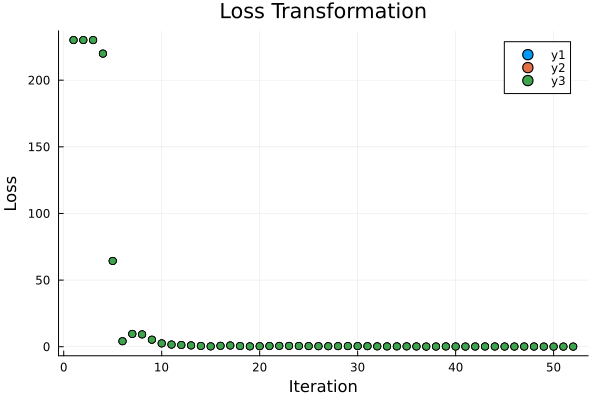

In [23]:
plt = scatter!(loss_values, title="Loss Transformation", xlabel="Iteration", ylabel="Loss")
# Generate a unique filename using the current timestamp
timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
filename = "loss_transformation_$timestamp.svg"
# Save the plot to a file
savefig(plt, filename)
plt

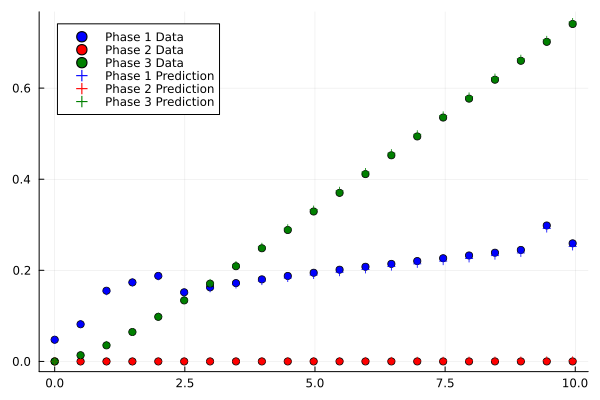

0.08370579129204668


false

In [24]:
callback(result_neuralode.u, loss_neuralode(result_neuralode.u)...; doplot = true)
#scatter!(plt, tsteps, loss_neuralode(result_neuralode.u)[2][1, :]; label = "prediction") # hide

In [25]:
display(predict_neuralode(result_neuralode.u)[:, :, 21])
display(ode_data[:, :, 21])

21×3 Matrix{Float64}:
 0.12564   0.0037985    0.870561
 0.125671  0.00367267   0.870656
 0.125714  0.0035511    0.870735
 0.125774  0.0034327    0.870793
 0.125877  0.00330701   0.870816
 0.126063  0.00317492   0.870763
 0.126368  0.00305077   0.870582
 0.126904  0.00292619   0.87017
 0.127855  0.00280079   0.869344
 0.129552  0.00267415   0.867774
 ⋮                      
 0.147834  0.00227046   0.849895
 0.165427  0.00211567   0.832457
 0.195528  0.00194346   0.802529
 0.250699  0.00172369   0.747577
 0.304958  0.0015517    0.69349
 0.434167  0.00121081   0.564622
 0.524223  0.000998409  0.474779
 0.742866  0.000523497  0.25661
 1.0       1.19279e-10  5.96534e-8

21×3 Matrix{Float64}:
 0.126618  7.83502e-17  0.873382
 0.126797  7.46682e-17  0.873203
 0.127014  7.16547e-17  0.872986
 0.127367  6.83049e-17  0.872633
 0.12789   6.49527e-17  0.87211
 0.128764  6.12613e-17  0.871236
 0.129967  5.78999e-17  0.870033
 0.131756  5.45307e-17  0.868244
 0.134415  5.11496e-17  0.865585
 0.138367  4.77511e-17  0.861633
 ⋮                      
 0.165958  3.73433e-17  0.834042
 0.185257  3.37378e-17  0.814743
 0.213945  3.00056e-17  0.786055
 0.25659   2.60851e-17  0.74341
 0.319983  2.18847e-17  0.680017
 0.414218  1.72683e-17  0.585782
 0.554302  1.20334e-17  0.445698
 0.737811  6.54736e-18  0.262189
 1.0       0.0          0.0

In [27]:
inputs = [0.1, flow_rate]
trained_model = result_neuralode.u
output, outst = nn(inputs, trained_model, st)
pp_Ea = output[1:Ea_size]
p_Ea = zeros(n, n)
index = 1
for i in 1:n
    for j in i+1:n
        p_Ea[i, j] = pp_Ea[index]
        p_Ea[j, i] = pp_Ea[index]
        index += 1
    end
end
# Segregate the output
display(p_Ea)
display(pe.Ea)
p_fcoeff = output[Ea_size+1:Ea_size+fcoeff_size]
p_precoeff = output[end]
display(p_fcoeff)
display(fcoeff)
display(p_precoeff)


3×3 Matrix{Float64}:
 0.0         0.16066   6.22539e-8
 0.16066     0.0       0.990316
 6.22539e-8  0.990316  0.0

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
 0.0   1.0  0.01
 1.0   0.0  1.0
 0.01  1.0  0.0

41-element Vector{Float64}:
 0.6881491099650049
 0.6096520721086036
 0.43709129618236775
 0.3586101314064274
 0.2870301165102352
 0.2727804250235229
 0.3232454264464142
 0.46959058576086493
 0.20682255520248555
 0.1863238737364783
 ⋮
 0.9998462273040707
 0.9997553931253376
 0.9999451226534211
 0.999844834526183
 0.9997529570333421
 0.999852714887547
 0.999635092973133
 0.9996339561644699
 0.4992634542981956

41-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.9999350021124542
 0.9999300024499428
 0.9999250028124297
 0.9999200031999147
 0.9999150036123976
 0.9999100040498785
 0.9999050045123571
 0.9999000049998333
 0.999895005512307

0.9943681385474726